In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
!nvidia-smi

Sun Feb  5 14:41:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  Off  | 00000000:18:00.0 Off |                    0 |
| N/A   28C    P0    36W / 250W |  14299MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-PCI...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   

In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [4]:
from ipywidgets import HTML
from ipyevents import Event 
from IPython.display import display
import torch
import pickle
from util import renormalize, viz_util, patch_util
import numpy as np
torch.set_grad_enabled(False)

In [5]:
pretrained_path = 'pretrained/stylegan3-r-ffhqu-256x256.pkl'
# pretrained_path = 'pretrained/bird_pretrained_final.pkl'
# pretrained_path = 'pretrained/church_pretrained_final.pkl'
# pretrained_path = 'pretrained/ffhq6k_pretrained_final.pkl'
# pretrained_path = 'pretrained/mountain_pretrained_final.pkl'

with open(pretrained_path, 'rb') as f:
    G_base = pickle.load(f)['G_ema'].cuda()  # torch.nn.Module

# interactive generation

In [44]:
!source sh/setup40.sh
rng = np.random.RandomState(0)
z = torch.from_numpy(rng.standard_normal(G_base.z_dim)).float()
z = z[None].cuda()
c = None
ws = G_base.mapping(z, c, truncation_psi=0.5, truncation_cutoff=8)

Autoloading gmp/6.2.1/gcc-7.5.0-2px2tki
Autoloading mpc/1.1.0/gcc-7.5.0-osodvlz
Autoloading mpfr/4.1.0/gcc-7.5.0-ublhnmp
Autoloading zlib/1.2.11/gcc-7.5.0-h3xiplk
Autoloading zstd/1.5.0/gcc-7.5.0-qsdxtru
Autoloading cuda/10.2.89/gcc-7.5.0-jr6kobf
Autoloading libxml2/2.9.9/gcc-7.5.0-ouvtc2l
Autoloading libiconv/1.16/gcc-7.5.0-pndwbk6
Autoloading xz/5.2.4/gcc-7.5.0-55h4brm
Autoloading zlib/1.2.11/gcc-7.5.0-dsnnbcq
Autoloading libxml2/2.9.12/gcc-7.5.0-i2j2pf5
Autoloading libiconv/1.16/gcc-7.5.0-cvte7wx
Autoloading xz/5.2.5/gcc-7.5.0-sytpwnz
Autoloading zlib/1.2.11/gcc-7.5.0-h3xiplk
>

In [45]:
params = {
    'patch_size': G_base.img_resolution,
    'display_size': min(400, G_base.img_resolution),
    'shift_rate': 10,
    'zoom_rate': 10,
}

In [46]:
# # open training-runs/SST750/00031-stylegan3-r-LR-gpus4-batch32-gamma2/network-snapshot-000012.pkl

# with open('training-runs/SST750/00031-stylegan3-r-LR-gpus4-batch32-gamma2/network-snapshot-000012.pkl', 'rb') as f:
#     G = pickle.load(f)['G_ema'].cuda()  # torch.nn.Module

In [51]:
from training.networks_stylegan3 import Generator
import dnnlib
scale_mapping_kwargs = dnnlib.EasyDict({'scale_mapping_min': 1,
                        'scale_mapping_max': 4,
                        'scale_mapping_norm': 'positive'})


pretrained_path = 'pretrained/stylegan3-r-ffhqu-256x256.pkl'

with open(pretrained_path, 'rb') as f:
    G_base = pickle.load(f)['G_ema'].cuda()  # torch.nn.Module
# , scale_mapping_kwargs=scale_mapping_kwargs
G_new = Generator(**G_base.init_kwargs, actual_resolution=256).cuda()
#old_state_dict = {k: v for k, v in G_new.state_dict().items() if v.shape == G_new.state_dict()[k].shape}
G_new.load_state_dict(G_base.state_dict(), strict=False)

cutoffs=array([  2.        ,   2.82842712,   4.        ,   5.65685425,
         8.        ,  11.3137085 ,  16.        ,  22.627417  ,
        32.        ,  45.254834  ,  64.        ,  90.50966799,
       128.        , 128.        , 128.        ])
cutoffs=array([  2.        ,   2.82842712,   4.        ,   5.65685425,
         8.        ,  11.3137085 ,  16.        ,  22.627417  ,
        32.        ,  45.254834  ,  64.        ,  90.50966799,
       128.        , 128.        , 128.        ])


<All keys matched successfully>

In [52]:
G_base = G_new

In [ ]:
img = patch_util.scale_condition_wrapper(G_base, ws, transform=None, noise_mode='const', force_fp32=True)
bbox_info = viz_util.init_bbox(params)

# get initial transformation
base_img = img[0]
generated_img, display_img = viz_util.update_img(bbox_info, True, True, None, None, params, G_base, ws)
transform = viz_util.bbox_to_transformation(bbox_info)[None].to(ws.device)

img_url = renormalize.as_url(viz_util.draw_bbox(bbox_info, base_img), source='pil', size=params['display_size'])
patch_url = renormalize.as_url(display_img, size=params['display_size'])
img_html = '<div class="row"> <img src="%s"/> <img src="%s"/> </div>' % (img_url, patch_url)
l = HTML(img_html)

text = HTML('Use arrow keys to pan, i to zoom in, o to zoom out, and c to reset.')
h = HTML('Full size: %d' % bbox_info['full_size'])
d = Event(source=l, watched_events=['keydown'])

def handle_event(event):
    global bbox_info
    global display_img
    global generated_img
    bbox_info, generated_img, display_img = viz_util.update_bbox(
        event['key'], bbox_info, generated_img, display_img, G_base, ws, params)
    img_url =  renormalize.as_url(viz_util.draw_bbox(bbox_info, base_img), source='pil', size=params['display_size'])
    patch_url = renormalize.as_url(display_img, size=params['display_size'])
    img_html = '<div class="row"> <img src="%s"/> <img src="%s"/> </div>' % (img_url, patch_url)
    l.value = img_html
    content = 'Full size: %d' % bbox_info['full_size']
    h.value = content

d.on_dom_event(handle_event)
display(text, h, l)

freqs.shape=torch.Size([1, 1024, 2]) | phases.shape=torch.Size([1, 1024])
grids.shape=torch.Size([1, 36, 36, 2]) | transforms.shape=torch.Size([1, 3, 3])
x.shape=torch.Size([1, 36, 36, 1024]) * amplitudes.shape=torch.Size([1, 1024])
x.shape=torch.Size([1, 36, 36, 1024]) @ weight.t().shape=torch.Size([1024, 1024])
x.shape=torch.Size([1, 36, 36, 1024]) after @
x.shape=torch.Size([1, 1024, 36, 36])


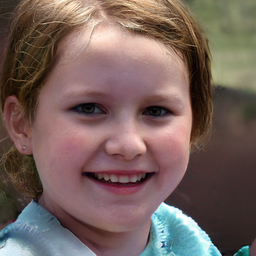

In [55]:
rng = np.random.RandomState(19)
z = torch.from_numpy(rng.standard_normal(G_base.z_dim)).float()
z = z[None].cuda()
c = None
ws = G_base.mapping(z, c, truncation_psi=0.5, truncation_cutoff=8)
img = patch_util.scale_condition_wrapper(G_base, ws, transform=None, noise_mode='const', force_fp32=True)
out256 = renormalize.as_image(img[0])
out256

freqs.shape=torch.Size([1, 1024, 2]) | phases.shape=torch.Size([1, 1024])
grids.shape=torch.Size([1, 36, 36, 2]) | transforms.shape=torch.Size([1, 3, 3])
x.shape=torch.Size([1, 36, 36, 1024]) * amplitudes.shape=torch.Size([1, 1024])
x.shape=torch.Size([1, 36, 36, 1024]) @ weight.t().shape=torch.Size([1024, 1024])
x.shape=torch.Size([1, 36, 36, 1024]) after @
x.shape=torch.Size([1, 1024, 36, 36])
freqs.shape=torch.Size([1, 1024, 2]) | phases.shape=torch.Size([1, 1024])
grids.shape=torch.Size([1, 36, 36, 2]) | transforms.shape=torch.Size([1, 3, 3])
x.shape=torch.Size([1, 36, 36, 1024]) * amplitudes.shape=torch.Size([1, 1024])
x.shape=torch.Size([1, 36, 36, 1024]) @ weight.t().shape=torch.Size([1024, 1024])
x.shape=torch.Size([1, 36, 36, 1024]) after @
x.shape=torch.Size([1, 1024, 36, 36])
freqs.shape=torch.Size([1, 1024, 2]) | phases.shape=torch.Size([1, 1024])
grids.shape=torch.Size([1, 36, 36, 2]) | transforms.shape=torch.Size([1, 3, 3])
x.shape=torch.Size([1, 36, 36, 1024]) * amplitud

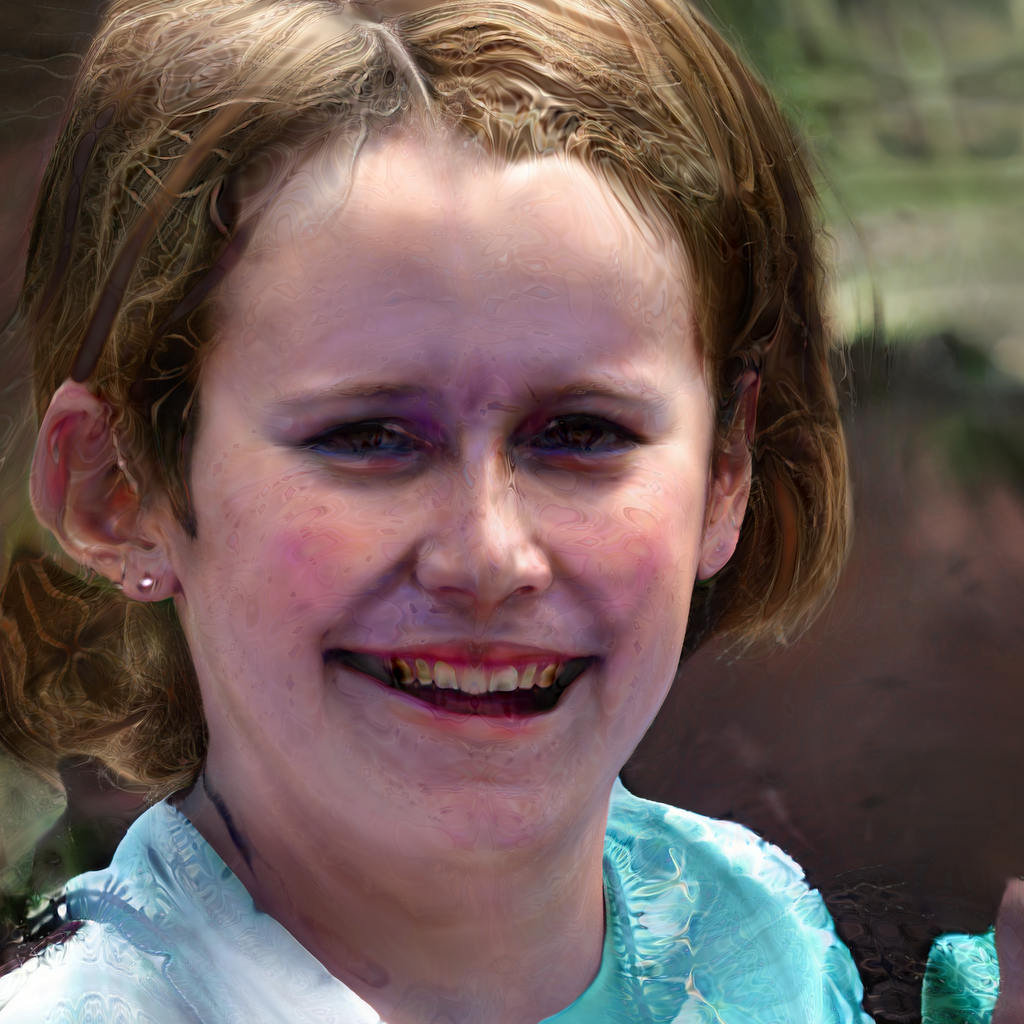

In [56]:
full_size = 1024
full = torch.zeros([1, 3, full_size, full_size])
patches = patch_util.generate_full_from_patches(full_size, G_base.img_resolution)
for bbox, transform in patches:
    img = patch_util.scale_condition_wrapper(G_base, ws, transform[None].cuda(), noise_mode='const', force_fp32=True)
    full[:, :, bbox[0]:bbox[1], bbox[2]:bbox[3]] = img
renormalize.as_image(full[0])

In [ ]:
out_256 = 

# panorama model

In [ ]:
pretrained_path = 'pretrained/mountain_pano_pretrained_final.pkl'
with open(pretrained_path, 'rb') as f:
    G_pano = pickle.load(f)['G_ema'].cuda()  # torch.nn.Module

In [ ]:
rng = np.random.RandomState(10)
z = torch.from_numpy(rng.standard_normal(G_pano.z_dim)).float()
z = z[None].cuda()
c = None

input_layer = G_pano.synthesis.input
grid = viz_util.make_grid(G_pano)
start_shift = np.random.randint(360 / input_layer.fov * input_layer.frame_size[0])
start_grid = grid[:, :, start_shift:start_shift+input_layer.size[0], :]
pano = viz_util.generate_pano_transform(G_pano, z, start_grid)
renormalize.as_image(pano)

In [ ]:
# splice the start and end of the pano together --> seamless image
pano_width = pano.shape[-1]
renormalize.as_image(torch.cat([pano, pano], dim=2)[:, :, pano_width-2*G_pano.img_resolution:pano_width+2*G_pano.img_resolution])